## Classification, Clustering, and Time Series Analysis of London Smart Meter Data

Energy consumption readings for a sample of 5,567 London Households that took part in the UK Power Networks led Low Carbon London project between November 2011 and February 2014.

Readings were taken at half hourly intervals. The customers in the trial were recruited as a balanced sample representative of the Greater London population.

The dataset contains energy consumption, in kWh (per half hour), unique household identifier, date and time. The CSV file is around 10GB when unzipped and contains around 167million rows.

Within the data set are two groups of customers. The first is a sub-group, of approximately 1100 customers, who were subjected to Dynamic Time of Use (dToU) energy prices throughout the 2013 calendar year period. The tariff prices were given a day ahead via the Smart Meter IHD (In Home Display) or text message to mobile phone. Customers were issued High (67.20p/kWh), Low (3.99p/kWh) or normal (11.76p/kWh) price signals and the times of day these applied. The dates/times and the price signal schedule is availaible as part of this dataset. All non-Time of Use customers were on a flat rate tariff of 14.228pence/kWh.

The signals given were designed to be representative of the types of signal that may be used in the future to manage both high renewable generation (supply following) operation and also test the potential to use high price signals to reduce stress on local distribution grids during periods of stress.

The remaining sample of approximately 4500 customers energy consumption readings were not subject to the dToU tariff.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom # This is for the unsupervised clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
def read_data():
    all_files = glob.glob("data/*.csv")
    
    li = [] # list for the .csv
    
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0, na_values = 0)
        li.append(df) # append all .csv to dataframe
        
    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

In [3]:
df = read_data() # get the data

In [4]:
df

,LCLid,stdorToU,DateTime,KWH/hh (per half hour),Acorn,Acorn_grouped
0,MAC000756,Std,2014-02-12 17:00:00.0000000,0.077,ACORN-E,Affluent
1,MAC000756,Std,2014-02-12 17:30:00.0000000,0.082,ACORN-E,Affluent
2,MAC000756,Std,2014-02-12 18:00:00.0000000,0.121,ACORN-E,Affluent
3,MAC000756,Std,2014-02-12 18:30:00.0000000,0.144,ACORN-E,Affluent
4,MAC000756,Std,2014-02-12 19:00:00.0000000,0.177,ACORN-E,Affluent
...,...,...,...,...,...,...
167932469,MAC000436,Std,2013-11-27 02:30:00.0000000,0.058,ACORN-L,Adversity
167932470,MAC000436,Std,2013-11-27 03:00:00.0000000,0.045,ACORN-L,Adversity
167932471,MAC000436,Std,2013-11-27 03:30:00.0000000,0.103,ACORN-L,Adversity
167932472,MAC000436,Std,2013-11-27 04:00:00.0000000,0.039,ACORN-L,Adversity


In [5]:
# Missing data.
df.fillna(0.0, inplace=True)
df.rename(columns={'KWH/hh (per half hour) ' : 'KWH/hh'}, inplace=True) # rename column to make easier to read.
df['KWH/hh'].replace('Null', 0, inplace=True)
df['KWH/hh'] = df['KWH/hh'].astype(float) 

In [6]:
df['DateTime'] = pd.to_datetime(df['DateTime']) # convert to datetime datetype

In [7]:
df.rename(columns={'Acorn_grouped_ACORN-' : 'Acorn_grouped_ACORN'}, inplace=True) # rename these col so I can drop them.
df.rename(columns={'Acorn_grouped_ACORN-U' : 'Acorn_grouped_ACORNU'}, inplace=True) # rename these col so I can drop them.

In [ ]:
df['Time'] = pd.to_datetime(df['DateTime']).dt.time

In [8]:
df # the intial clean dataframe.

,LCLid,stdorToU,DateTime,KWH/hh,Acorn,Acorn_grouped
0,MAC000756,Std,2014-02-12 17:00:00,0.077,ACORN-E,Affluent
1,MAC000756,Std,2014-02-12 17:30:00,0.082,ACORN-E,Affluent
2,MAC000756,Std,2014-02-12 18:00:00,0.121,ACORN-E,Affluent
3,MAC000756,Std,2014-02-12 18:30:00,0.144,ACORN-E,Affluent
4,MAC000756,Std,2014-02-12 19:00:00,0.177,ACORN-E,Affluent
...,...,...,...,...,...,...
167932469,MAC000436,Std,2013-11-27 02:30:00,0.058,ACORN-L,Adversity
167932470,MAC000436,Std,2013-11-27 03:00:00,0.045,ACORN-L,Adversity
167932471,MAC000436,Std,2013-11-27 03:30:00,0.103,ACORN-L,Adversity
167932472,MAC000436,Std,2013-11-27 04:00:00,0.039,ACORN-L,Adversity


## Uncomment if you want to save the clean df as a feather file. 

Reading and Writing to this file type cut the time to read and write to 2 minutes and 1 minute respectively. You must install pyarrow to use. 

In [ ]:
# import pyarrow.feather as feather
# feather.write_feather(df, 'clean_data.feather')

In [9]:
df.Acorn_grouped.value_counts() # Some EDA

Affluent       67359986
Adversity      54288852
Comfortable    44833553
ACORN-U         1412799
ACORN-            37284
Name: Acorn_grouped, dtype: int64

In [10]:
# drop the rows that have one of the bewlow values in 'Acorn_grouped'
df = df.drop(df[(df.Acorn_grouped == "ACORN-U") | (df.Acorn_grouped == "ACORN-")].index)

In [11]:
df.shape

(166482391, 6)

In [12]:
# write the clean full df to disk.

# df.to_csv("C:\\Users\\jesse\\Downloads\\clases\\electrical data\\london data\\data\\all_clean_data.csv") # full dataset

# Summary stats

In [14]:
gk_2 = df.groupby(['Acorn_grouped', 'stdorToU']) # group by to do more EDA.

### Not sure this is the best way to do this. It takes quite a long time. 

In [15]:
groups = dict(list(gk_2)) # makes a dict of dataframs which can be accesed below. 

In [16]:
Adversity_Std = groups['Adversity', 'Std']
Adversity_ToU = groups['Adversity', 'ToU']
Affluent_Std = groups['Affluent', 'Std']
Affluent_ToU = groups['Affluent', 'ToU']
Comfortable_Std = groups['Comfortable', 'Std']
Comfortable_ToU = groups['Comfortable', 'ToU']

In [17]:
gk_2.describe().round(3) # 5 number summary.

KWH/hh                                          \
                             count   mean    std  min    25%    50%    75%   
Acorn_grouped stdorToU                                                       
Adversity     Std       45414941.0  0.180  0.239  0.0  0.055  0.107  0.208   
              ToU        8873911.0  0.170  0.218  0.0  0.051  0.102  0.199   
Affluent      Std       52243126.0  0.246  0.361  0.0  0.059  0.123  0.274   
              ToU       15116860.0  0.219  0.305  0.0  0.056  0.114  0.246   
Comfortable   Std       35361116.0  0.214  0.276  0.0  0.065  0.126  0.251   
              ToU        9472437.0  0.193  0.240  0.0  0.062  0.118  0.228   

                                
                           max  
Acorn_grouped stdorToU          
Adversity     Std        8.285  
              ToU        6.234  
Affluent      Std       10.761  
              ToU        7.567  
Comfortable   Std        9.257  
              ToU        6.498

In [18]:
(gk_2.size()/31000).round(0) # how many series belong to each group.

Acorn_grouped  stdorToU
Adversity      Std         1465.0
               ToU          286.0
Affluent       Std         1685.0
               ToU          488.0
Comfortable    Std         1141.0
               ToU          306.0
dtype: float64

In [19]:
Comfortable_ToU.describe().round(3) # more EDA.

,KWH/hh
count,9472437.000
mean,0.193
std,0.240
min,0.000
25%,0.062
50%,0.118
75%,0.228
max,6.498


## TO-DO: I need to find a way to slice all the indivual series to begain and end at the same time by timedate stamp.

In [20]:
Adversity_Std['Time'] = pd.to_datetime(Adversity_Std['DateTime']).dt.time
# Adversity_Std.groupby(pd.Grouper(key='DateTime', freq='1D'))

In [39]:
for x, y in Adversity_Std.groupby("Time"):
    print(x, y)

00:00:00                 LCLid stdorToU  KWH/hh    Acorn Acorn_grouped      Time
DateTime                                                               
2012-04-21  MAC000757      Std   0.081  ACORN-O     Adversity  00:00:00
2012-04-22  MAC000757      Std   0.063  ACORN-O     Adversity  00:00:00
2012-04-23  MAC000757      Std   0.082  ACORN-O     Adversity  00:00:00
2012-04-24  MAC000757      Std   0.096  ACORN-O     Adversity  00:00:00
2012-04-25  MAC000757      Std   0.105  ACORN-O     Adversity  00:00:00
...               ...      ...     ...      ...           ...       ...
2013-11-24  MAC000436      Std   0.048  ACORN-L     Adversity  00:00:00
2013-11-25  MAC000436      Std   0.037  ACORN-L     Adversity  00:00:00
2013-11-26  MAC000436      Std   0.096  ACORN-L     Adversity  00:00:00
2013-11-27  MAC000436      Std   0.059  ACORN-L     Adversity  00:00:00
2013-11-27  MAC000436      Std   0.059  ACORN-L     Adversity  00:00:00

[977302 rows x 6 columns]
00:30:00                    

In [21]:
# from datetime import datetime # this code block doesnt work.

# Adversity_Std = Adversity_Std.set_index('DateTime')
# Adversity_Std[Adversity_Std.slice_indexer("2013-01-01", "2013-12-30")]

AttributeError: 'DataFrame' object has no attribute 'slice_indexer'

In [22]:
## Make time series dataframe and output for analysis in R.
df_ts = df.drop(columns=["stdorToU", "Acorn", "Acorn_grouped"], inplace=False) # make ts matrix
# df_ts.to_csv("C:\\Users\\jesse\\Downloads\\clases\\electrical data\\london data\\data\\TS_clean_data.csv") # full dataset

In [23]:
df_ts

,LCLid,DateTime,KWH/hh
0,MAC000756,2014-02-12 17:00:00,0.077
1,MAC000756,2014-02-12 17:30:00,0.082
2,MAC000756,2014-02-12 18:00:00,0.121
3,MAC000756,2014-02-12 18:30:00,0.144
4,MAC000756,2014-02-12 19:00:00,0.177
...,...,...,...
167932469,MAC000436,2013-11-27 02:30:00,0.058
167932470,MAC000436,2013-11-27 03:00:00,0.045
167932471,MAC000436,2013-11-27 03:30:00,0.103
167932472,MAC000436,2013-11-27 04:00:00,0.039


In [24]:
gk = df_ts.groupby('LCLid') # group by ID to be able to look at the start and end dates so as to figure out where to slice.
# for the above TO-DO.

In [25]:
min(gk.first().DateTime) # earlist start

Timestamp('2011-11-23 09:00:00')

In [26]:
 max(gk.first().DateTime) # latest start

Timestamp('2014-02-13 11:30:00')

In [27]:
min(gk.last().DateTime) # earlist stop

Timestamp('2012-03-27 03:30:00')

In [28]:
 max(gk.last().DateTime) # latest stop

Timestamp('2014-02-28 00:00:00')

### Make df for minisom.

In [29]:
# This is me trying to build a DF that I will use for clustering. 

In [30]:
df_num = df.drop(columns=["LCLid", "stdorToU", "DateTime", "Acorn"], inplace=False) # make num matrix
df_num = pd.get_dummies(df_num)
np_df = np.matrix(df_num) # dataframe for minisom.

In [31]:
np_df

matrix([[0.077, 0.   , 1.   , 0.   ],
        [0.082, 0.   , 1.   , 0.   ],
        [0.121, 0.   , 1.   , 0.   ],
        ...,
        [0.103, 1.   , 0.   , 0.   ],
        [0.039, 1.   , 0.   , 0.   ],
        [0.065, 1.   , 0.   , 0.   ]])

### Testing some plotting

In [32]:
MAC004221_df = df[df['LCLid'] == 'MAC004221'] # A single smart meter. i.e. one whole series. 

In [33]:
MAC004221_df.value_counts()

LCLid      stdorToU  DateTime             KWH/hh  Acorn    Acorn_grouped
MAC004221  Std       2014-02-28 00:00:00  0.061   ACORN-E  Affluent         2
                     2013-10-27 00:00:00  0.042   ACORN-E  Affluent         2
                     2013-02-21 00:00:00  0.064   ACORN-E  Affluent         2
                     2012-11-20 00:00:00  0.070   ACORN-E  Affluent         2
                     2013-09-26 00:00:00  0.041   ACORN-E  Affluent         2
                                                                           ..
                     2012-12-24 14:00:00  0.470   ACORN-E  Affluent         1
                     2012-12-24 13:30:00  0.748   ACORN-E  Affluent         1
                     2012-12-24 13:00:00  0.276   ACORN-E  Affluent         1
                     2012-12-24 12:30:00  0.053   ACORN-E  Affluent         1
                     2013-04-11 05:00:00  0.070   ACORN-E  Affluent         1
Length: 30980, dtype: int64

In [34]:
sns.set(rc={'figure.figsize':(14,14)})

<AxesSubplot:xlabel='DateTime', ylabel='KWH/hh'>

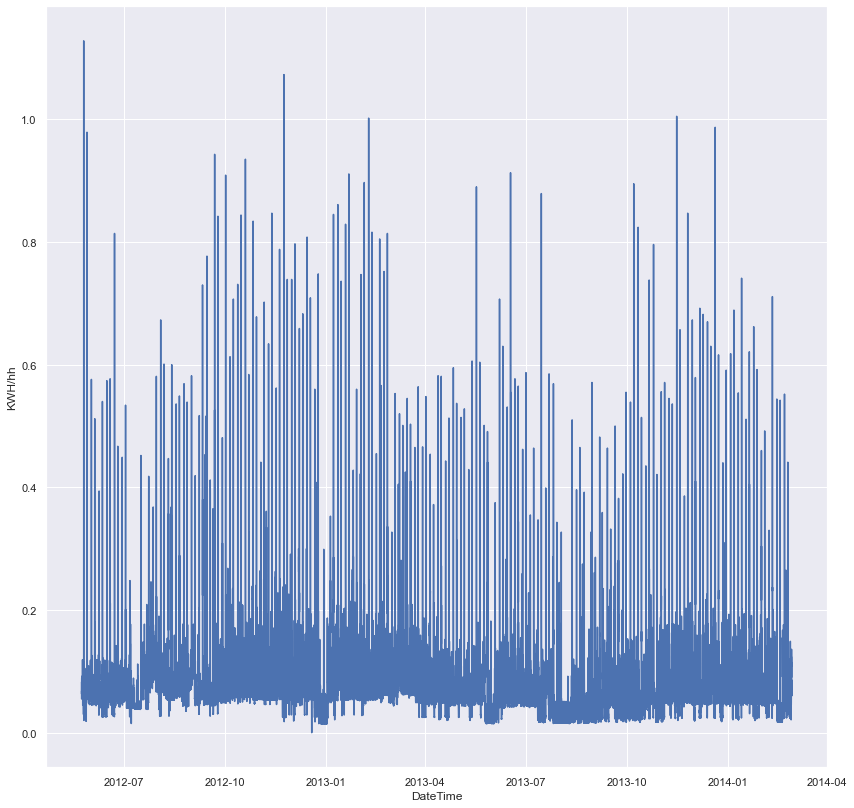

In [35]:
sns.lineplot(data=MAC004221_df, x="DateTime", y="KWH/hh")